# Simple synthetic time series with anomalies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

## Univariate

In [2]:
def add_anomalies_to_univariate_series(
	x: np.ndarray,
	normal_duration_rate: float,
	anomaly_duration_rate: float,
	anomaly_size_range: tuple[float, float],
):
	"""Add anomalies to a given time series.

	Args:
	    x: The series to add anomalies to.
	    normal_duration_rate: Average duartion of a normal interval.
	    anomaly_duration_rate: Average duartion of a anomalous interval.
	    anomaly_size_range: A range where the magnitude of the anomaly lies.
	        E.g. if this is (0.5, 0.8), then a random value in that interval with be
	        added or subtracted from the series in the anomaly interval.
	"""
	# Validate the anomaly size range.
	if anomaly_size_range[0] >= anomaly_size_range[1]:
		raise ValueError(
			f"The anomaly size range {anomaly_size_range} should be strictly increasing."
		)

	# Copy x in order to not overwrite it.
	x = x.copy()
	N = len(x)
	# Define two exponential distributions which describe the lengths of normal and anomalous intervals.
	# So e.g. stats.expon(scale=20) will sample a duration of an anomalous interval with mean 20.
	distr_duration_normal = stats.expon(scale=normal_duration_rate)
	distr_duration_anomalous = stats.expon(scale=anomaly_duration_rate)

	# Loop over a max number of intervals and add the anomalies.
	max_number_of_intervals = 8
	location = 0
	anom_locs = []
	for _ in range(max_number_of_intervals):
		# First sample a normal interval. The anomaly will start at the end of it.
		random_states = np.random.randint(0, np.iinfo(np.int32).max, size=2)
		anom_start = location + int(
			distr_duration_normal.rvs(random_state=random_states[0])
		)
		# Then sample an anomalous interval. The anomaly will end at the end of it.
		anom_end = anom_start + int(
			distr_duration_anomalous.rvs(random_state=random_states[1])
		)
		# Make sure we don't exceed the length of the series.
		anom_end = min(N, anom_end)

		if anom_start >= N:
			break

		# The anomaly shifts the signal up or down to the interval [-0.8, -0.5] or [0.5, 0.8].
		shift_sign = 1 if np.random.randint(low=0, high=2) == 1 else -1
		shift = shift_sign * np.random.uniform(
			anomaly_size_range[0], anomaly_size_range[1], size=anom_end - anom_start
		)
		x[anom_start:anom_end] += shift
		# Update the location to the end of the anomaly.
		location = anom_end

		# mark the indices of anomaly for creating labels
		anom_locs.append((anom_start, anom_end))

	return (x, anom_locs)

In [3]:
# Fix the random state of numpy.
np.random.seed(42)

# Generate a time series of length 1000 with i.i.d. values with distribution N(0, 0.1^2).
N = 1000
x = np.random.normal(0, 0.1, size=N)

# Add anomalies.
(x, anom_locs) = add_anomalies_to_univariate_series(
	x, normal_duration_rate=400, anomaly_duration_rate=20, anomaly_size_range=(0.5, 0.8)
)

# Add labels - 0: normal; 1: anomalies
labels = np.zeros(N)
for i in range(len(anom_locs)):
	labels[anom_locs[i][0] : anom_locs[i][1]] = 1

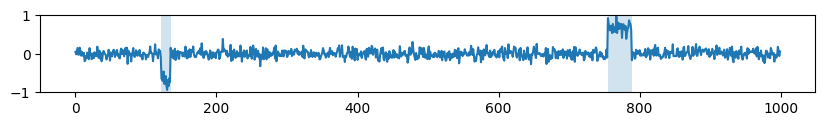

In [4]:
# Plot the series with labels
plt.figure(figsize=(10, 1))
plt.plot(x)
plt.ylim((-1, 1))

for i in range(len(anom_locs)):
	plt.axvspan(anom_locs[i][0], anom_locs[i][1], alpha=0.2)

plt.show()

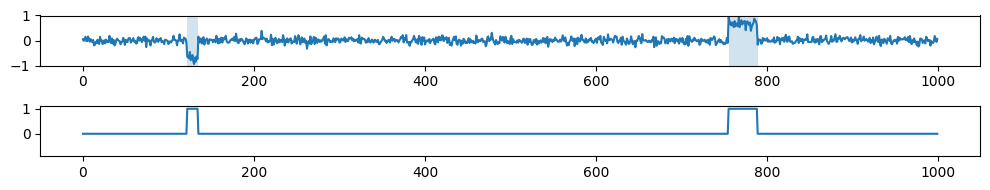

In [5]:
# plot signals, anomaly, and labels
_, ax = plt.subplots(2, 1, figsize=(10, 2))

ax[0].plot(x)
ax[0].set_ylim((-1, 1))
for i in range(len(anom_locs)):
	ax[0].axvspan(anom_locs[i][0], anom_locs[i][1], alpha=0.2)

ax[1].plot(labels)
ax[1].set_ylim((-0.9, 1.1))

plt.tight_layout()
plt.show()

## Multivariate
The same idea as with univariate, just adding the anomalies to a couple of features.

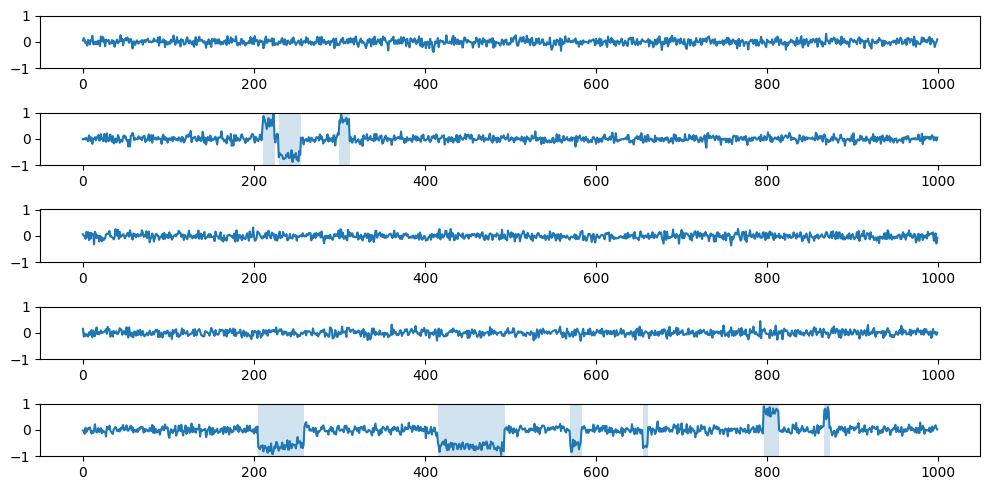

In [6]:
# Fix the random state of numpy.
np.random.seed(42)

# Generate a time series of length 1000 and 20 features with i.i.d. values with distribution N(0, 0.1^2).
# This assumes that anomalies are independent from each feature

N = 1000
n_features = 20
x = np.random.normal(0, 0.1, size=(N, 20))

# Add anomaly location
rows, cols = (n_features, 1)
anom_locs = [[() for i in range(cols)] for j in range(rows)]

# Add anomalies only on features 1 and 4.
(x[:, 1], anom_locs[1]) = add_anomalies_to_univariate_series(
	x[:, 1],
	normal_duration_rate=400,
	anomaly_duration_rate=20,
	anomaly_size_range=(0.5, 0.8),
)
(x[:, 4], anom_locs[4]) = add_anomalies_to_univariate_series(
	x[:, 4],
	normal_duration_rate=400,
	anomaly_duration_rate=20,
	anomaly_size_range=(0.5, 0.8),
)

# Plot some of the features.
first_n_features = 5
_, ax = plt.subplots(first_n_features, 1, figsize=(10, first_n_features))

for i in range(first_n_features):
	ax[i].plot(x[:, i])
	ax[i].set_ylim((-1, 1))

	if i in (1, 4):
		for j in range(len(anom_locs[i])):
			ax[i].axvspan(anom_locs[i][j][0], anom_locs[i][j][1], alpha=0.2)

plt.tight_layout()
plt.show()